# U - Net
## Problem: 

Seismic data is collected using reflection seismology, or seismic reflection. The method requires a controlled seismic source of energy, such as compressed air or a seismic vibrator, and sensors record the reflection from rock interfaces within the subsurface. The recorded data is then processed to create a 3D view of earth’s interior. Reflection seismology is similar to X-ray, sonar and echolocation.

A seismic image is produced from imaging the reflection coming from rock boundaries. The seismic image shows the boundaries between different rock types. In theory, the strength of reflection is directly proportional to the difference in the physical properties on either sides of the interface. While seismic images show rock boundaries, they don't say much about the rock themselves; some rocks are easy to identify while some are difficult.

There are several areas of the world where there are vast quantities of salt in the subsurface. One of the challenges of seismic imaging is to identify the part of subsurface which is salt. Salt has characteristics that makes it both simple and hard to identify. Salt density is usually 2.14 g/cc which is lower than most surrounding rocks. The seismic velocity of salt is 4.5 km/sec, which is usually faster than its surrounding rocks. This difference creates a sharp reflection at the salt-sediment interface. Usually salt is an amorphous rock without much internal structure. This means that there is typically not much reflectivity inside the salt, unless there are sediments trapped inside it. The unusually high seismic velocity of salt can create problems with seismic imaging.

### Data
The data is a set of images chosen at various locations chosen at random in the subsurface. The images are 101 x 101 pixels and each pixel is classified as either salt or sediment. In addition to the seismic images, the depth of the imaged location is provided for each image. The goal of the competition is to segment regions that contain salt.

#### Source: 
https://www.kaggle.com/c/tgs-salt-identification-challenge


### Note: 
Accept the terms and download data from the above link

### Aim: 

Implement U-Net neural model architecture in keras to solve this problem.


In this, you are asked to segment salt deposits beneath the Earth’s surface. Given a set of seismic images that are 101 x 101 pixels each and each pixel we need to classify as either salt or sediment. Our goal is to segment regions that contain salt. A seismic image is produced from imaging the reflection coming from rock boundaries. The seismic image shows the boundaries between different rock types. 

### Broad Steps:

1. Download the dataset
2. Upload to Drive
3. Import from drive to colab
4. Load the images and create training data.
5. Build U-net Model
6. Train your model.
7. Check the validation accuracy and plot sample.

In [0]:
#Importing necessary libraries
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [13]:
#Mount drive
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


### 1.Set your project path where you have your data and related files for this lab.

In [0]:
import os
os.chdir('/content/drive/My Drive/Residency_9/External_lab/')

In [0]:
project_path = "/content/drive/My Drive/Residency_9/External_lab/"

### 2. Set the necessary parameters

## Setup

In [0]:
im_width = 128      #width of your train image
im_height = 128     #hight of your train image
#border =        
path_train = project_path + 'train/'   #Path for your train data

# 3. Make directory for train data at in your project/lab folder.

Hint - use !mkdir function.

# 4. Extract your train images to the train directory you have just created above. 
train.zip and test.zip files available at your google drive/local system.

As a good practice - Upload or copy the data at your project path folder.

Make sure you are providing the right project_path.

In [0]:
#For simplicity we have added the required code here.
from zipfile import ZipFile

with ZipFile(project_path + 'train.zip', 'r') as zf:
  zf.extractall('train/')


In [0]:
#The train file have both images and masks with the same names_ids.

### 5. Get the list of names of images and masks and name the list imagelist and masklist.

Hint - Use os.listdir() funtions.

In [0]:
imagelist = os.listdir('/content/drive/My Drive/Residency_9/External_lab/train/images')

In [0]:
masklist = os.listdir('/content/drive/My Drive/Residency_9/External_lab/train/masks')

In [28]:
#Test your list names by printing some of the names as given below.
print(imagelist[-1])
print(masklist[-1])
print(imagelist[10])
print(masklist[10])

7cc53fe88b.png
7cc53fe88b.png
de08c5a3b7.png
de08c5a3b7.png


# 6. Read and test your images and respective masks.

Hint -

import  matplotlib.pyplot as plt

import cv2

plt.imshow(cv2.imread('path of image'))

plt.imshow(cv2.imread('path of mask'))


In [0]:
import matplotlib.pyplot as plt
import cv2

In [35]:
imagelist[1]

'e045664b46.png'

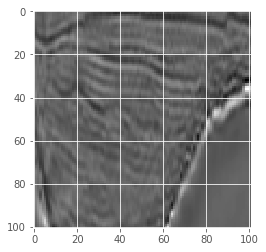

In [46]:
plt.imshow(cv2.imread('/content/drive/My Drive/Residency_9/External_lab/train/images/5b7c160d0d.png'))

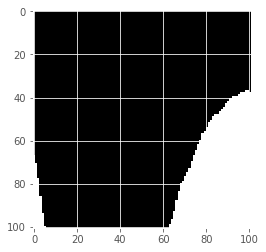

In [47]:
plt.imshow(cv2.imread('/content/drive/My Drive/Residency_9/External_lab/train/masks/5b7c160d0d.png'))

# 7. Create your training data.

Hints - 

image_path = os.path.join(project_path +'path of your image directory' +n )

mask_path = os.path.join(project_path +'path of your mask directory'+n )

In [52]:
# Get and resize train images and masks
def get_data():
    X = np.zeros(((len(imagelist), im_height, im_width, 1)), dtype=np.float32) # Create an array for image
    y = np.zeros(((len(masklist), im_height, im_width, 1)), dtype=np.float32) #Create an array for mask
    
    for n in imagelist: 
        k = imagelist.index(n)
        ##Add image_path
        image_path =  os.path.join(project_path + 'train/' + 'images/' +n )
        ##Add mask_path
        mask_path =  os.path.join(project_path + 'train/' + 'masks/' +n )                                                          
        
        # Load images and resize to (128,128,1)
        img = load_img(image_path)
        x = img_to_array(img)[:,:,1]
        resized_img = resize(x, (128, 128, 1), mode='constant', preserve_range=True)
                
        # Load masks and resize to (128,128,1)
        img = load_img(image_path)
        m = img_to_array(img)[:,:,1]
        resized_mask = resize(m, (128, 128, 1), mode='constant', preserve_range=True)
                
        # Save images
        X[k, ..., 0] = resized_img.squeeze() / 255
        y[k] = resized_mask/255
    print('Done!')
    #if train:
    return X, y
    #else:
    #    return X
    
X, y = get_data()

Done!


In [0]:
# Split train and valid
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.15, random_state=2019)

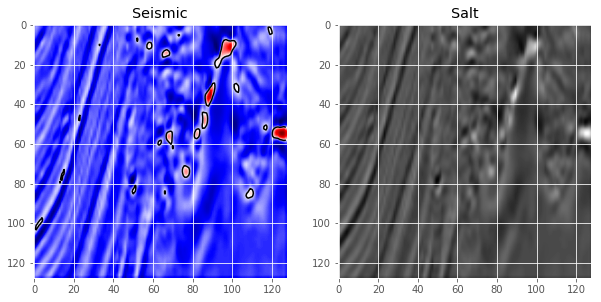

In [54]:
## Test your data whether it looks fine - Random check
import random 
# Check if training data looks all right
ix = random.randint(0, len(X_train))
has_mask = y_train[ix].max() > 0

fig, ax = plt.subplots(1, 2, figsize=(10, 10))

ax[0].imshow(X_train[ix, ..., 0], cmap='seismic', interpolation='bilinear')
if has_mask:
    ax[0].contour(y_train[ix].squeeze(), colors='k', levels=[0.5])
ax[0].set_title('Seismic')

ax[1].imshow(y_train[ix].squeeze(), interpolation='bilinear', cmap='gray')
ax[1].set_title('Salt');




### 8. Define loss and dice_coeff function.

In [0]:
from keras import backend as K

In [0]:
def dice_loss(y_true, y_pred, smooth=1e-6):
    """ Loss function base on dice coefficient.

    Parameters
    ----------
    y_true : keras tensor
        tensor containing target mask.
    y_pred : keras tensor
        tensor containing predicted mask.
    smooth : float
        small real value used for avoiding division by zero error.

    Returns
    -------
    keras tensor
        tensor containing dice loss.
    """
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    answer = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return -answer


In [0]:
def dice_coef(y_true, y_pred):
    
    y_true_f = K.batch_flatten(y_true)
    y_pred_f = K.batch_flatten(y_pred)
    intersection = 2. * K.sum(y_true_f * y_pred_f, axis=1, keepdims=True) + smooth
    union = K.sum(y_true_f, axis=1, keepdims=True) + K.sum(y_pred_f, axis=1, keepdims=True) + smooth
        
    return K.mean(intersection / union)

### 9. Build and compile UNet Model for your data.

Hint - 
You can install and use segmentation models from this github repository.

#Install segmentation models

!pip install git+https://github.com/qubvel/segmentation_models

In [82]:
!pip install git+https://github.com/qubvel/segmentation_models

  Cloning https://github.com/qubvel/segmentation_models to /tmp/pip-req-build-x2mydod_
  Running command git clone -q https://github.com/qubvel/segmentation_models /tmp/pip-req-build-x2mydod_
  Running command git submodule update --init --recursive -q
  Created wheel for segmentation-models: filename=segmentation_models-1.0.0b1-cp36-none-any.whl size=33618 sha256=9ed31fdc74318960454ddc392c06eb8beb561757edf51431ecab2a77b083f94c
  Stored in directory: /tmp/pip-ephem-wheel-cache-b65qalin/wheels/49/cf/46/cbb4bb64518c402aea99df9d466f1081450597e653256bbcf4
Successfully built segmentation-models


In [0]:
import segmentation_models as sm

In [0]:
#model = Unet(backbone_name='resnet34', encoder_weights=None, input_shape=(None, None, 1))
#compile your model by adding the parameters like optimizer, loss and metrics.
import segmentation_models as sm

BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

# load your data
# x_train, y_train, x_val, y_val = load_data(...)

# preprocess input
X_train = preprocess_input(X_train)
X_valid = preprocess_input(X_valid)

# define model
model = sm.Unet(BACKBONE, encoder_weights=None, input_shape=(None, None, 1))
model.compile(
    'Adam',
    loss=sm.losses.bce_dice_loss,
    metrics=[sm.metrics.iou_score],
)

In [85]:
#Get the summary of your model
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, None, None, 1 0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, None, None, 1 3           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_35 (ZeroPadding2 (None, None, None, 1 0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, None, None, 6 3136        zero_padding2d_35[0][0]          
__________________________________________________________________________________________________
bn0 (Batch

### 10. Fit your model using model.fit function.
Hint - As it might take long time to run. Run it for only 1 or 2 epochs.

In [86]:
# fit model
# if you use data generator use model.fit_generator(...) instead of model.fit(...)
# more about `fit_generator` here: https://keras.io/models/sequential/#fit_generator
model.fit(
   X_train,
   y_train,
   batch_size=16,
   epochs=2,
   validation_data=(X_valid, y_valid),
)

Train on 3400 samples, validate on 600 samples
Epoch 1/2
3400/3400 [==============================] - 86s 25ms/step - loss: 1.1039 - iou_score: 0.3885 - val_loss: 1.1483 - val_iou_score: 0.3889
Epoch 2/2
3400/3400 [==============================] - 67s 20ms/step - loss: 1.0964 - iou_score: 0.3920 - val_loss: 1.0926 - val_iou_score: 0.3913


### 11.Predict on val set using model.predict funtion and store in preds_val variable.



In [0]:
y_val_pred = model.predict(X_valid)
preds_val = y_val_pred

In [0]:
#Get the threshold predictions to look at refined results.
preds_val_t = (preds_val > 0.5).astype(np.uint8)

In [0]:
#Plot a sample
def plot_sample(X, y, preds, binary_preds, ix=None):
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='seismic')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Seismic')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Salt')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Salt Predicted')
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Salt Predicted binary');

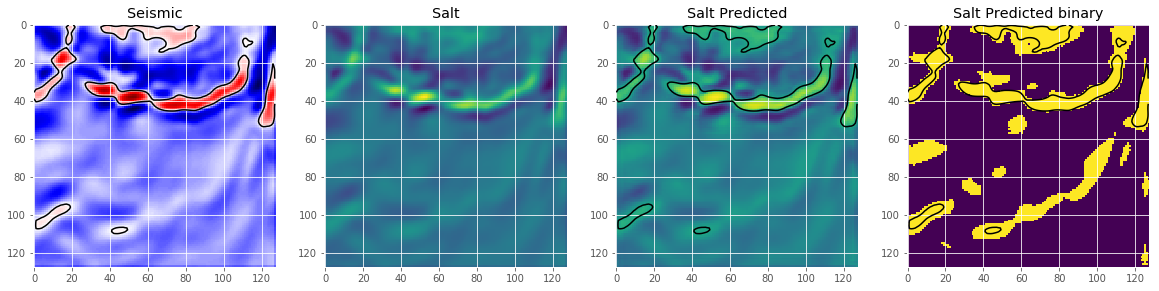

In [91]:
# Check if valid data looks all right
plot_sample(X_valid, y_valid, preds_val, preds_val_t, ix=15)

If you are getting good results- Congratulations.
If you are not, try to explore what might be the reason.

# Text generation using a RNN

Given a sequence of words from this data, train a model to predict the next word in the sequence. Longer sequences of text can be generated by calling the model repeatedly.

**Mount your Google Drive**

In [1]:
#Mount drive
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
import os
os.chdir('/content/drive/My Drive/Residency_9/External_lab/')

### Import Keras and other libraries

In [3]:
import glob
from sklearn.utils import shuffle
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout, Embedding, Masking, Bidirectional, SimpleRNN
from keras.optimizers import Adam
from keras import optimizers
from keras import backend

Using TensorFlow backend.


## Download data
Reference: Data is collected from http://www.gutenberg.org

For the lab purpose, you can load the dataset provided by Great Learning

### Load the Oscar Wilde dataset

Store all the ".txt" file names in a list

In [0]:
oscalist = glob.glob('/content/drive/My Drive/NLP/Sequence NLP/oscarwilde_data/data/data/*.txt')

In [5]:
oscalist

['/content/drive/My Drive/NLP/Sequence NLP/oscarwilde_data/data/data/The Ballad of Reading Gaol.txt',
 '/content/drive/My Drive/NLP/Sequence NLP/oscarwilde_data/data/data/The Canterville Ghost.txt',
 '/content/drive/My Drive/NLP/Sequence NLP/oscarwilde_data/data/data/Shorter Prose Pieces.txt',
 '/content/drive/My Drive/NLP/Sequence NLP/oscarwilde_data/data/data/The Importance of Being Earnest.txt',
 '/content/drive/My Drive/NLP/Sequence NLP/oscarwilde_data/data/data/Selected prose of oscar wilde with a Preface by Robert Ross.txt',
 '/content/drive/My Drive/NLP/Sequence NLP/oscarwilde_data/data/data/The Picture of Dorian Gray.txt',
 '/content/drive/My Drive/NLP/Sequence NLP/oscarwilde_data/data/data/The Happy Prince and other tales.txt',
 '/content/drive/My Drive/NLP/Sequence NLP/oscarwilde_data/data/data/The Duchess of Padua.txt',
 '/content/drive/My Drive/NLP/Sequence NLP/oscarwilde_data/data/data/Vera or, The Nihilists.txt',
 '/content/drive/My Drive/NLP/Sequence NLP/oscarwilde_data/

### Read the data

Read contents of every file from the list and append the text in a new list

In [0]:
codetext = []
bookranges = []

for oscafile in oscalist:
  oscatext = open(oscafile, 'r')
  start = len(codetext)
  codetext.append(oscatext.read())
  end = len(codetext)
  bookranges.append({'start': start, 'end': end, 'name': oscafile.rsplit('/',-1)[-1]})
  oscatext.close()

## Process the text
Initialize and fit the tokenizer

In [0]:
tokenizer = Tokenizer(lower=True, filters='!"#$%()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(codetext)

### Vectorize the text

Before training, we need to map strings to a numerical representation. Create two lookup tables: one mapping words to numbers, and another for numbers to words.

In [0]:
word_idx = tokenizer.word_index
idx_word = tokenizer.index_word

Get the word count for every word and also get the total number of words.

In [0]:
word_counts = tokenizer.word_counts
num_words = len(word_idx) + 1

In [10]:
num_words

14790

Convert text to sequence of numbers

In [0]:
sequences = tokenizer.texts_to_sequences(codetext)

### Generate Features and Labels

In [0]:
features = []
labels = []

training_length = 50

for seq in sequences:
  
  for i in range(training_length, training_length+300):
    
    extract = seq[i - training_length: i - training_length +20]
    
    features.append(extract[:-1])
    labels.append(extract[-1])

### The prediction task

Given a word, or a sequence of words, what is the most probable next word? This is the task we're training the model to perform. The input to the model will be a sequence of words, and we train the model to predict the output—the following word at each time step.

Since RNNs maintain an internal state that depends on the previously seen elements, given all the words computed until this moment, what is the next word?

### Generate training and testing data

In [0]:
from sklearn.utils import shuffle
import numpy as np

features, labels = shuffle(features, labels, random_state=1)

train_end = int(0.7 * len(labels))

train_features = np.array(features[:train_end])
valid_features = np.array(features[train_end:])

train_labels = labels[:train_end]
valid_labels = labels[train_end:]

X_train, X_valid = np.array(train_features), np.array(valid_features)

y_train = np.zeros((len(train_labels), num_words), dtype=np.int8)
y_valid = np.zeros((len(valid_labels), num_words), dtype=np.int8)

for example_index, word_index in enumerate(train_labels):
  y_train[example_index, word_index] = 1
  
for example_index, word_index in enumerate(valid_labels):
  y_valid[example_index, word_index] = 1

This is just to check the features and labels

In [14]:
for i, sequence in enumerate(X_train[:2]):
  text = []
  
  for idx in sequence:
    text.append(idx_word[idx])
    
    print('Features: ' + ' '.join(text)+'\n')
    print('Labels: ' + idx_word[np.argmax(y_train[i])] +'\n')

Features: paul

Labels: by

Features: paul redmond

Labels: by

Features: paul redmond picture

Labels: by

Features: paul redmond picture book

Labels: by

Features: paul redmond picture book cover

Labels: by

Features: paul redmond picture book cover picture

Labels: by

Features: paul redmond picture book cover picture the

Labels: by

Features: paul redmond picture book cover picture the happy

Labels: by

Features: paul redmond picture book cover picture the happy prince

Labels: by

Features: paul redmond picture book cover picture the happy prince the

Labels: by

Features: paul redmond picture book cover picture the happy prince the happy

Labels: by

Features: paul redmond picture book cover picture the happy prince the happy prince

Labels: by

Features: paul redmond picture book cover picture the happy prince the happy prince and

Labels: by

Features: paul redmond picture book cover picture the happy prince the happy prince and other

Labels: by

Features: paul redmond pic

## Build The Model

Use `keras.Sequential` to define the model. For this simple example three layers are used to define our model:

* `keras.layers.Embedding`: The input layer. A trainable lookup table that will map the numbers of each character to a vector with `embedding_dim` dimensions;
* `keras.layers.LSTM`: A type of RNN with size `units=rnn_units` (You can also use a GRU layer here.)
* `keras.layers.Dense`: The output layer, with `num_words` outputs.

In [15]:
model = Sequential()
# Embedding layer
model.add(Embedding(input_dim=len(word_idx) + 1, output_dim=100, weights=None,trainable=True))
# Recurrent layer
model.add(LSTM(64,return_sequences=False, dropout=0.1, recurrent_dropout=0.1))
# Fully connected layer
model.add(Dense(64, activation='relu'))
# Dropout for regularization
model.add(Dropout(0.5))
# Output layer
model.add(Dense(num_words, activation='softmax'))
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

W0810 04:45:51.075559 139869826623360 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0810 04:45:51.126185 139869826623360 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0810 04:45:51.133681 139869826623360 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0810 04:45:51.287016 139869826623360 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0810 04:45:51.302458 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 100)         1479000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                42240     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 14790)             961350    
Total params: 2,486,750
Trainable params: 2,486,750
Non-trainable params: 0
_________________________________________________________________


For each word the model looks up the embedding, runs the LSTM one timestep with the embedding as input, and applies the dense layer to generate logits predicting the log-liklihood of the next word.

## Train the model

In [16]:
h = model.fit(X_train, y_train, epochs=500, batch_size=50, verbose=1)

W0810 04:46:10.626776 139869826623360 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/500
2100/2100 [==============================] - 6s 3ms/step - loss: 9.2664 - acc: 0.0581
Epoch 2/500
2100/2100 [==============================] - 2s 930us/step - loss: 6.8428 - acc: 0.0648
Epoch 3/500
2100/2100 [==============================] - 2s 976us/step - loss: 6.4498 - acc: 0.0700
Epoch 4/500
2100/2100 [==============================] - 2s 971us/step - loss: 6.2644 - acc: 0.0705
Epoch 5/500
2100/2100 [==============================] - 2s 924us/step - loss: 6.1493 - acc: 0.0700
Epoch 6/500
2100/2100 [==============================] - 2s 921us/step - loss: 6.0387 - acc: 0.0700
Epoch 7/500
2100/2100 [==============================] - 2s 927us/step - loss: 5.9618 - acc: 0.0705
Epoch 8/500
2100/2100 [==============================] - 2s 922us/step - loss: 5.8797 - acc: 0.0690
Epoch 9/500
2100/2100 [==============================] - 2s 936us/step - loss: 5.8173 - acc: 0.0667
Epoch 10/500
2100/2100 [==============================] - 2s 924us/step - loss: 5.7820 - acc: 0.0681
E

### Save Model

In [0]:
model.save('/data_model_500epochs.h5')

## If you have already trained the model and saved it, you can load a pretrained model

In [0]:
model = load_model('/data_model_500epochs.h5')

### Note: After loading the model run  model.fit()  to continue training form there, if required.

In [19]:
h1 = model.fit(X_train, y_train, epochs=100, batch_size=50, verbose=1)

Epoch 1/100
2100/2100 [==============================] - 3s 1ms/step - loss: 0.2168 - acc: 0.9262
Epoch 2/100
2100/2100 [==============================] - 2s 967us/step - loss: 0.2228 - acc: 0.9257
Epoch 3/100
2100/2100 [==============================] - 2s 956us/step - loss: 0.2242 - acc: 0.9262
Epoch 4/100
2100/2100 [==============================] - 2s 951us/step - loss: 0.1953 - acc: 0.9329
Epoch 5/100
2100/2100 [==============================] - 2s 951us/step - loss: 0.2104 - acc: 0.9300
Epoch 6/100
2100/2100 [==============================] - 2s 934us/step - loss: 0.1961 - acc: 0.9333
Epoch 7/100
2100/2100 [==============================] - 2s 949us/step - loss: 0.2306 - acc: 0.9181
Epoch 8/100
2100/2100 [==============================] - 2s 940us/step - loss: 0.2330 - acc: 0.9238
Epoch 9/100
2100/2100 [==============================] - 2s 949us/step - loss: 0.2151 - acc: 0.9276
Epoch 10/100
2100/2100 [==============================] - 2s 937us/step - loss: 0.2003 - acc: 0.9333
E

## Evaluation

In [20]:
model.evaluate(X_valid, y_valid, batch_size=50, verbose=1)

900/900 [==============================] - 1s 709us/step


[10.757117801242405, 0.28333333424395984]

## Generate text

In [0]:
y_pred = model.predict(X_train)

In [22]:
for i, sequence in enumerate(X_train[:3]):
  text = []
  
  for idx in sequence:
    
    text.append(idx_word[idx])
    
    print('Features: ' + ' '.join(text)+'\n')
    print('Labels: ' + idx_word[np.argmax(y_pred[i])] +'\n')

Features: paul

Labels: by

Features: paul redmond

Labels: by

Features: paul redmond picture

Labels: by

Features: paul redmond picture book

Labels: by

Features: paul redmond picture book cover

Labels: by

Features: paul redmond picture book cover picture

Labels: by

Features: paul redmond picture book cover picture the

Labels: by

Features: paul redmond picture book cover picture the happy

Labels: by

Features: paul redmond picture book cover picture the happy prince

Labels: by

Features: paul redmond picture book cover picture the happy prince the

Labels: by

Features: paul redmond picture book cover picture the happy prince the happy

Labels: by

Features: paul redmond picture book cover picture the happy prince the happy prince

Labels: by

Features: paul redmond picture book cover picture the happy prince the happy prince and

Labels: by

Features: paul redmond picture book cover picture the happy prince the happy prince and other

Labels: by

Features: paul redmond pic

## Time Series Analysis using LSTM

### Download Data
Link: https://datamarket.com/data/set/2324/daily-minimum-temperatures-in-melbourne-australia-1981-1990#!ds=2324&display=line

#### Description
Daily minimum temperatures in Melbourne, Australia, 1981-1990

Units: Degrees Celcius

#### Steps before loading
- Rename the column name with temperature values to "Temperature"
- In the last, there is one extra row in the data, remove it by opening the file and save it again.
- There are some values in Temperature column which have a "?" before them, they will give error, remove "?" before them and save the file
- If you don't want to do these steps, just load the data file given by Great Learning.

### Import required libraries

In [0]:
# Import the necessary libraries

from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import GRU, Dense
from keras.layers import LSTM
from keras  import callbacks
from keras import optimizers
import pandas as pd 
import tensorflow as tf
import numpy as np

#### Mount google drive

In [24]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Load the  data file

In [25]:
df = pd.read_csv('/content/drive/My Drive/Residency_9/External_lab/daily-minimum-temperatures-in-me (1).csv', index_col='Date')
print(df.head())

          Temperature
Date                 
1/1/1981         20.7
1/2/1981         17.9
1/3/1981         18.8
1/4/1981         14.6
1/5/1981         15.8


### Plot the data

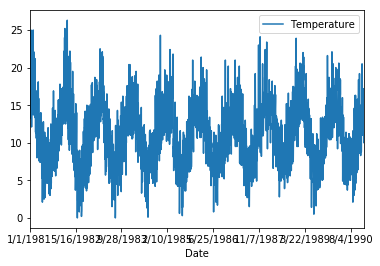

In [26]:
df.plot()

### Check for null values and treat them

In [27]:
df.isnull().sum()

Temperature    0
dtype: int64

#### Drop null values (if any)

In [0]:
# No null values

### Get the representation of the distribution of data in the form of histogram

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f35ae257b00>]],
      dtype=object)

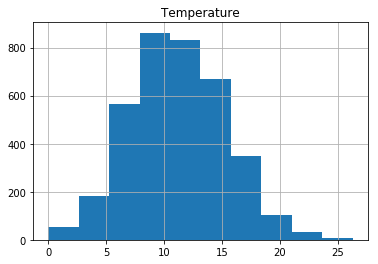

In [28]:
df.hist(bins=10)

### Check the maximum and minimum values

In [29]:
# Scaled Data
print('Min', np.min(df))
print('Max', np.max(df))

Min Temperature    0.0
dtype: float64
Max Temperature    26.3
dtype: float64


### Normalize the data

In [0]:
dataset = df.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(dataset)

### Check the maximum and minimum values of scaled data

In [32]:
print('Min', np.min(scaled))
print('Max', np.max(scaled))

Min 0.0
Max 1.0


### Split data into Training and Testing set 
<u>Note</u> The train and test data has to be sequential. Keep the first 70% of data in training and the bottom 30% in test data 

In [33]:
#Create the model
train_size = int(len(scaled) * 0.70)
test_size = len(scaled - train_size)
train, test = scaled[0:train_size, :], scaled[train_size: len(scaled), :]
print('train: {}\ntest: {}'.format(len(train), len(test)))

train: 2555
test: 1095


## Create the sequential data
Map the temperature at a particular time t to the temperature at time t+n, where n is any number you define.

For example: to map temperatures of consecutive days, use t+1, i.e. loop_back = 1

#### Define your function to create dataset

In [0]:
def create_dataset(dataset, look_back=1):
    print(len(dataset), look_back)
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        print(i)
        print('X {} to {}'.format(i, i+look_back))
        print(a)
        print('Y {}'.format(i + look_back))
        print(dataset[i + look_back, 0])
        dataset[i + look_back, 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

### Use function to get training and test set

In [35]:
look_back = 1
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

2555 1
0
X 0 to 1
[0.7870723]
Y 1
0.6806083702582986
1
X 1 to 2
[0.68060837]
Y 2
0.7148288890658444
2
X 2 to 3
[0.71482889]
Y 3
0.5551331104563756
3
X 3 to 4
[0.55513311]
Y 4
0.6007604809535642
4
X 4 to 5
[0.60076048]
Y 5
0.6007604809535642
5
X 5 to 6
[0.60076048]
Y 6
0.6007604809535642
6
X 6 to 7
[0.60076048]
Y 7
0.6615969628626882
7
X 7 to 8
[0.66159696]
Y 8
0.8288973334395067
8
X 8 to 9
[0.82889733]
Y 9
0.7604562958244149
9
X 9 to 10
[0.7604563]
Y 10
0.6159696286268815
10
X 10 to 11
[0.61596963]
Y 11
0.5057034439755123
11
X 11 to 12
[0.50570344]
Y 12
0.6349810360224919
12
X 12 to 13
[0.63498104]
Y 13
0.817490518011246
13
X 13 to 14
[0.81749052]
Y 14
0.9505703697805186
14
X 14 to 15
[0.95057037]
Y 15
0.7870722951873749
15
X 15 to 16
[0.7870723]
Y 16
0.7832699992037001
16
X 16 to 17
[0.78327]
Y 17
0.9429657778131689
17
X 17 to 18
[0.94296578]
Y 18
0.6730038508137127
18
X 18 to 19
[0.67300385]
Y 19
0.5893536292639215
19
X 19 to 20
[0.58935363]
Y 20
0.6920152582093231
20
X 20 to 21
[0.6

### Transform the prepared train and test input data into the expected structure using numpy.reshape()

In [36]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_train.shape)
print(X_test.shape)

(2553, 1, 1)
(1093, 1, 1)


### Define sequntial model, add LSTM layer and compile the model

In [0]:
batch_size = 1 

model = Sequential()

model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')


### Train the model for 100 epochs with batch size = 1

In [38]:
model.fit(X_train, y_train, epochs=100, batch_size=batch_size, verbose=2, shuffle=True)

Epoch 1/100
 - 16s - loss: 0.0176
Epoch 2/100
 - 15s - loss: 0.0143
Epoch 3/100
 - 15s - loss: 0.0124
Epoch 4/100
 - 15s - loss: 0.0117
Epoch 5/100
 - 15s - loss: 0.0111
Epoch 6/100
 - 15s - loss: 0.0108
Epoch 7/100
 - 15s - loss: 0.0107
Epoch 8/100
 - 15s - loss: 0.0105
Epoch 9/100
 - 15s - loss: 0.0103
Epoch 10/100
 - 15s - loss: 0.0103
Epoch 11/100
 - 15s - loss: 0.0103
Epoch 12/100
 - 15s - loss: 0.0102
Epoch 13/100
 - 15s - loss: 0.0103
Epoch 14/100
 - 15s - loss: 0.0101
Epoch 15/100
 - 15s - loss: 0.0102
Epoch 16/100
 - 15s - loss: 0.0102
Epoch 17/100
 - 15s - loss: 0.0101
Epoch 18/100
 - 15s - loss: 0.0101
Epoch 19/100
 - 15s - loss: 0.0102
Epoch 20/100
 - 15s - loss: 0.0101
Epoch 21/100
 - 15s - loss: 0.0101
Epoch 22/100
 - 15s - loss: 0.0101
Epoch 23/100
 - 15s - loss: 0.0102
Epoch 24/100
 - 15s - loss: 0.0101
Epoch 25/100
 - 15s - loss: 0.0102
Epoch 26/100
 - 15s - loss: 0.0102
Epoch 27/100
 - 15s - loss: 0.0101
Epoch 28/100
 - 15s - loss: 0.0102
Epoch 29/100
 - 15s - loss: 0

### Make Predictions and Evaluate your model

In [39]:
import math
from sklearn.metrics import mean_squared_error

trainPredict = model.predict(X_train, batch_size=batch_size)

model.reset_states()

testPredict = model.predict(X_test, batch_size=batch_size)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
y_train = scaler.inverse_transform([y_train])
testPredict = scaler.inverse_transform(testPredict)
y_test = scaler.inverse_transform([y_test])

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 2.74 RMSE
Test Score: 2.63 RMSE
